# 1.0 Setup

## 1.1 Package Imports

In [73]:
import pandas as pd
import geopandas as gpd
import pykrige
from pyidw import idw
from sklearn.metrics import mean_squared_error
import rasterio
from matplotlib import pyplot as plt

## 1.2 Data Import

In [8]:
path = r'G:\My Drive\Geospatial Data Science with Python\Data\\'

In [65]:
# Ohio Shapefile
ohio = gpd.read_file(path + "Ohio\Ohio.shp")
ohio_state = ohio.dissolve()
ohio_state = ohio_state[['STATEFP','geometry']]
ohio_state = ohio_state.to_crs("EPSG:4326")
ohio_state.to_file(path + "Ohio\Ohio_State.shp")

# Ohio Temperatures
temps = pd.read_csv(path + "Chapter 11\Ohio Temps.csv")
temps = temps[~temps['TAVG'].isnull()]
temps = temps[temps['DATE']=='2022-01-01']
temps = temps[['LATITUDE','LONGITUDE','TAVG']]

# Converting to geopandas and writing out as shapefile
temps_gpdf = gpd.GeoDataFrame(
    temps,
    geometry=gpd.points_from_xy(temps['LONGITUDE'],
                                   temps['LATITUDE'],
                                   crs="EPSG:4326")
)

# Output the shapefile
temps_gpdf.to_file(path + "Chapter 11\Ohio Temps.shp")

C:\Users\TEST\AppData\Local\Temp\ipykernel_14496\3257989157.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  temps = pd.read_csv(path + "Chapter 11\Ohio Temps.csv")


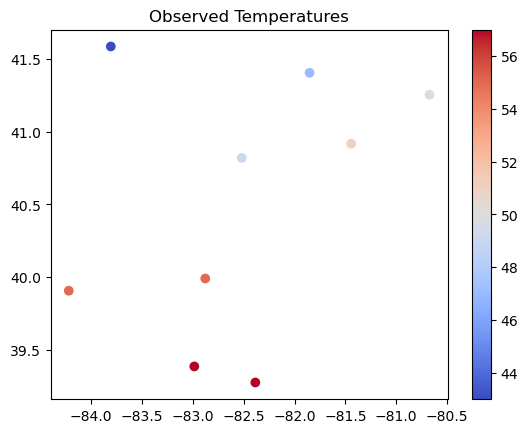

In [259]:
# Dropping the geometry column
temps_nogeom = temps.drop(['geometry'], axis=1)

# Converting the DataFrame to a numpy array
temps_array = temps_nogeom.to_numpy()

# Plot the observations
obs = plt.scatter(temps_array[:, 1],
    temps_array[:, 0],
    c = temps_array[:, 2], cmap='coolwarm')
cbar = plt.colorbar(obs)
plt.title('Observed Temperatures')
plt.show()

# 2.0 Spatial Interpolation

## 2.1 Inverse Distance Weighted Interpolation

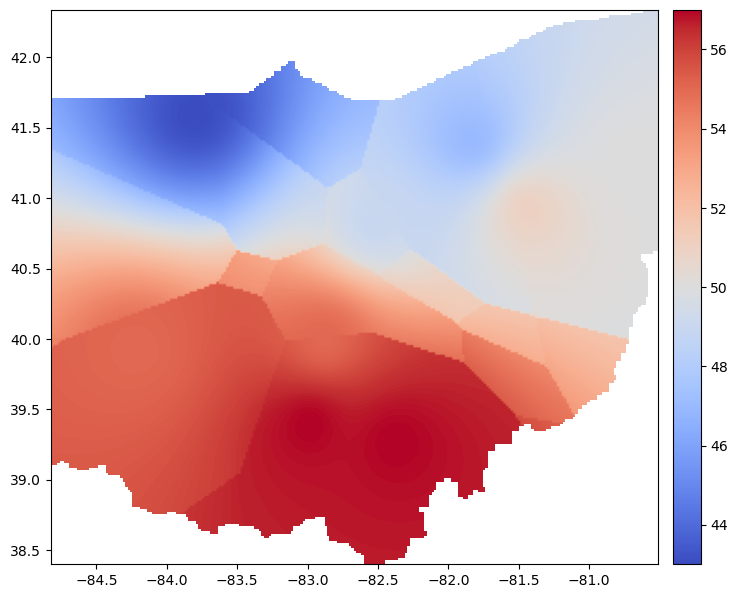

In [225]:
idw.idw_interpolation(
    input_point_shapefile="G:\My Drive\Geospatial Data Science with Python\Data\Chapter 11\Ohio Temps.shp",
    extent_shapefile="G:\My Drive\Geospatial Data Science with Python\Data\Ohio\Ohio_State.shp",
    column_name="TAVG",
    power=2,
    search_radious=3,
    output_resolution=250
)

## 2.2 Oridinary Kriging Interpolation

In [190]:
# Package Imports
import matplotlib.pyplot as plt
import numpy as np
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [211]:
min_x = min(temps_nogeom['LONGITUDE'])
max_x = max(temps_nogeom['LONGITUDE'])
min_y = min(temps_nogeom['LATITUDE'])
max_y = max(temps_nogeom['LATITUDE'])

gridx = np.arange(min_x, max_x, 0.1, dtype='float64')
gridy = np.arange(min_y, max_y, 0.1, dtype='float64')

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 22.766398103091955
Full Sill: 22.76639810309213
Range: 2.3536346423355963
Nugget: 1.7370036924355214e-13 



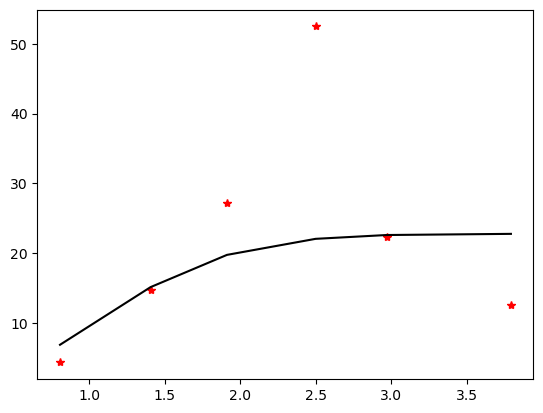

Calculating statistics on variogram model fit...


In [214]:
Orid_Krig = OrdinaryKriging(
    temps_array[:, 1], #Longitude vector
    temps_array[:, 0], #Latitude vector
    temps_array[:, 2], #Temperatures vector
    variogram_model="gaussian", #The semivariogram model
    verbose=True, #True writes out the steps as they're being performed
    enable_plotting=True # True plots the emperical semivariogram
)

In [215]:
# Interpolate the values using the kriging model
z, ss = Orid_Krig.execute("grid", gridx, gridy)

Executing Ordinary Kriging...



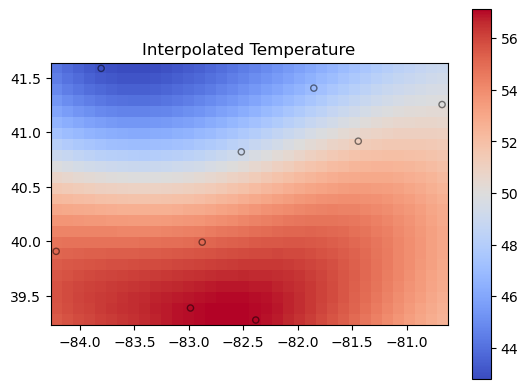

In [257]:
# Plot the interpolarted values and sampled points
im = plt.imshow(z, extent=[min_x-.05, max_x+.05, min_y-.05, max_y+.05], origin='lower', cmap='coolwarm')
plt.scatter(temps_array[:, 1],
    temps_array[:, 0],
    c = temps_array[:, 2], alpha=.5, marker='o', s=20, edgecolors='black', linewidth=1, cmap='coolwarm')
cbar = plt.colorbar(im)
plt.title("Interpolated Temperature")
plt.show()